# DL session 2 challenge: Gandalf or Dumbledore?


## Introduction
In this challenge we will train a neural network to distinguish between two different types of images using convolutional nerual networks.

In particular, we will train a model that can distinguish between images of Gandalf (from _Lord of the Rings_) and Dumbledore (from _Harry Potter_).

This is a challenging visual task for a few reasons:
 * Both are grey-bearded old white men
 * Both wear wizard robes and hats
 * Two different actors played Dumbledore (yes, we will ignore the Jude Law incarnation), Richard Harris and Michael Gambon, and they did not look very much alike. In fact, you could argue that Michael Gambon looks much more like Ian McKellen than like Richark Harris.
 * Gandalf has two incarnations that look significantly different: Gandalf the Grey and Gandalf the White

With a very limited training set of images, this task would be close to impossible if we were training a neural network from scratch.

Thankfully, but we will not start from scratch. We will use Transfer Learning to benefit from the representations learned by other networks previously trained on huge datasets with many image classes, and apply those representations to our much more specific problem, with much more limited data.

## Rules

 * Start by making your own copy of this notebook.
 * You are be provided with a very small training set of images form both classes. This is on purpose, so that you notice the power of Tranfer Learning. 
 * You can use as much data augmentation as you want, and use any kind of inner split (train/validation split) for validation or cross-validation, but your can't add new images.
 * You can use whichever DL framework and API you want, although I suggest that you use Keras in this case.
 * You must set the seed of any pseudorandom functions
 * You must submit two files:
   * This notebook with your code, which should be abble to run from start to finish in Colab without any errors.
   * A file with your saved model. If you are usingn keras, this would be the output of `model.save("your-model-name.h5")`. The notebook should include code able to load this file correctly, which if you are using keras should be something like `model = tf.keras.models.load_model("your-model-name.h5")`
 * The models will be scored against a test set that I will keep hidden. The scoring metric will be binary accuracy. In keras this is `tf.keras.metrics.BinaryAccuracy`.
 * The submission with the higgest accuracy will win this week's prize. In case of a tie, we wil also evaluate by best practices and code quality.

## Suggested resources

 * Easy way to manipulate an image dataset with Keras: https://keras.io/api/preprocessing/image/
 * You will probably find this Transfer Learning example in Keras very useful: https://keras.io/examples/vision/image_classification_efficientnet_fine_tuning/
 * Data augmentation layers in Keras: https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing
 * There are many pre-trained state-of-art models available directly through the Keras API, such as EfficientNet: https://keras.io/api/applications/efficientnet/

## Setup

First, we will install and load all of the libraries we will be using.

Please update it as you need, importing whatever libraries you use in your code.

## Setup

* Imports:

> Include any imports you need in the cell below. 
> 
> I have included some imports to give you hints on what you might want to make use of.

In [82]:
import os
import shutil
import time

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

from random import choices
from PIL import Image
from google_drive_downloader import GoogleDriveDownloader as gdd
from sklearn.model_selection import train_test_split
from tensorflow.python.data.ops.dataset_ops import BatchDataset

* Globals: 

In [83]:
SEED = 1534

TRAIN_PATH = '/content/train_data/'
TEST_PATH  = '/content/test_data/'

IMG_SIZE = (224, 224)  # Default, depends on EfficientNet type; in this case B1 was chosen
BATCH_SIZE = 32        # Default

## Dataset

You can download the training data by running the cell below. You will get the following folder structure:

```
train_data
 |_ dumbledore
    |_ dumbledore_0000.jpg
    |_ dumbledore_0001.jpg
    |_ dumbledore_0002.jpg
    |_ ...
 |_ gandalf
    |_ gandalf_0000.jpg
    |_ gandalf_0001.jpg
    |_ gandalf_0002.jpg
```

In [84]:
def get_train_data():
    gdd.download_file_from_google_drive(
        file_id = '16uUSJevLSCx4DO5x-FQ-2jVv43HH5UcP',
        dest_path = './train_data.zip',
    )
    shutil.unpack_archive("./train_data.zip", extract_dir=".")

In [85]:
get_train_data()

----------
#### PREPROCESSING:
* **[1]** DATA SPLIT: Separating data into: 
  * train: `0.9*0.82 = 0.74`
  * validation:  `0.9*0.28 = 0.26`
  * test: `0.1`

In order to do this, we implement a function that takes some imgs from the `TRAIN_PATH` and moves them to the `TEST_PATH`.

Train and validation are separated with `image_dataset_from_directory` in order to return both datasets as tf objects.

* **[2]** DATA AUGMENTATION: Since there is very little data available for training and validation, we use augmentation techniques in order to get more samples.

For this, tf has implemented `flow_from_directory` which unifies both the split and the augmentation in one step. [+](https://datascience.stackexchange.com/questions/78405/image-dataset-from-directory-vs-flow-from-directory)

In [86]:
def saparate_data(
    source_path: str = TRAIN_PATH, 
    target_path: str = TEST_PATH,
    split_percentage: float = 0.85
  ):
  """ Takes some files from the TRAIN_PATH and moves them to TEST_PATH, creating 
  the folders along the way if they do not exist.


  Args:
    source_path (str): directory where the data is currently stored
    target_path (str): directory where some that is going to be moved
    split_percentage (float): base 1 number hat indicates the quantity of data to
      keep at source_path
    
  Returns:
    None
  """

  # functions for process: index as dependant from img folder len
  get_split_index = lambda p: int(len(p) * split_percentage)

  if not os.path.exists(target_path): os.makedirs(target_path)

  for f in os.listdir(source_path):
    if not f.startswith('.'):

      subfolders = tuple(map(lambda p: p+f+'/', 
                            [source_path, target_path])
      ) # Note: (source_subfolder, target_subfolder)
      print("SUBFOLDERS: {:<35} -> {:<40}".format(*subfolders), end = '\t')

      if not os.path.exists(subfolders[1]): os.makedirs(subfolders[1])
      
      imgs = sorted(os.listdir(subfolders[0]))  
      # TODO: Eliminar imgs corruptas
      
      split_index = get_split_index(imgs)

      #f_train = imgs[:split_index]
      f_test  = imgs[split_index:]
      print("NUM ITEMS [{}:]: {:<5} - > {:<5}".format(
          split_index, len(imgs),len(f_test)), end='\n')

      for img in f_test:
        shutil.move(src=subfolders[0] + img, 
                    dst=subfolders[1] + img
        )

  # end

In [87]:
saparate_data()

SUBFOLDERS: /content/train_data/dumbledore/     -> /content/test_data/dumbledore/          	NUM ITEMS [34:]: 41    - > 7    
SUBFOLDERS: /content/train_data/gandalf/        -> /content/test_data/gandalf/             	NUM ITEMS [34:]: 40    - > 6    


In [88]:
def train_val_test_tfds_split(
    validation_split: float = .25,
    ):

  """_stringdoc_todo

  Args: 
    validation_split (float): percentage of imgs to keep for validation
  
  Returns:
    List[tf.Dataset]
  """
  # Variables
  subsets = ['training', 'validation', 'test']
  common_params = {
      "label_mode": 'binary',
      "seed": SEED,
      "image_size": IMG_SIZE,
      "batch_size": BATCH_SIZE
  }

  # Iter through subset types
  for subset in subsets: 
    if 'test' != subset:
      print(subset.upper())
      yield tf.keras.preprocessing.image_dataset_from_directory(
          directory=TRAIN_PATH,
          validation_split = validation_split,
          subset = subset,
          **common_params
      )    

    else:
      print(subset.upper())
      yield tf.keras.preprocessing.image_dataset_from_directory(
          directory=TEST_PATH,
          **common_params
      )
      
    print()

In [89]:
train_set, validation_set, test_set = list(train_val_test_tfds_split())

TRAINING
Found 67 files belonging to 2 classes.
Using 51 files for training.

VALIDATION
Found 67 files belonging to 2 classes.
Using 16 files for validation.

TEST
Found 13 files belonging to 2 classes.



In [90]:
type(train_set)

tensorflow.python.data.ops.dataset_ops.BatchDataset

In [91]:
NUM_CLASSES = len(train_set.class_names)
display(train_set.class_names)

['dumbledore', 'gandalf']

In [92]:
def print_sample(
    sample_size: int, 
    tfds : BatchDataset,
    fgs: int
  ):
  """ Funtion that plots a set number of images from a tensorflow dataset in a 
  set figure size.

  Args:
    sample_size (int): 
    tfds (BatchDataset):
    figsize (int)
  
  Returns:
    Nonetype: only plots a matrix of sample_size images from tfds
  """
  plt.figure(figsize = tuple([fgs]*2))

  try:
    class_names = tfds.class_names
  except:
    class_names = False

  for img, label in tfds.take(1):
    for i in range(sample_size): 

      ax = plt.subplot(1, sample_size, i+1)

      plt.imshow(img[i].numpy().astype('uint8'))
      if class_names: plt.title(tfds.class_names[int(label[i])])
      
      plt.axis('off')

    # end

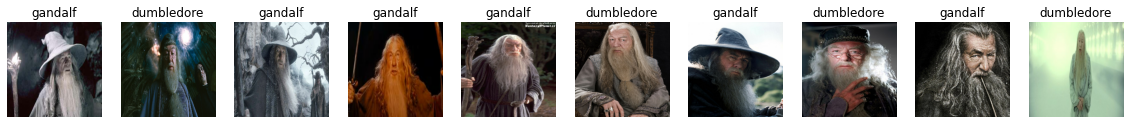

In [93]:
print_sample(
    sample_size=10, 
    tfds=train_set,
    fgs=20
)

Img Preprocesing - Data Aumentation
 * Binarize categories: Hashing
 * Random transformations:
     - random contrast: RandomRotation
     - random crop: RandomCrop
     - random zoom: RandomFLip

In [94]:
from tensorflow.keras import layers

In [95]:
# creamon fuera de la CNN la parte del data augmentation para echarle un ojo

data_augmentation = tf.keras.Sequential(
    [   
        layers.RandomContrast(factor=(0.03,0.06)),
        #layers.RandomCrop(int(IMG_SIZE[0]*0.7), int(IMG_SIZE[1]*0.7), seed = SEED),
        layers.RandomRotation(factor= (-0.1, 0.1), seed=SEED),
        layers.RandomFlip(seed=SEED)
    ]
)

In [96]:
augmented_train_set = train_set.map(
    lambda x, y: (data_augmentation(x, training=True), y)
)

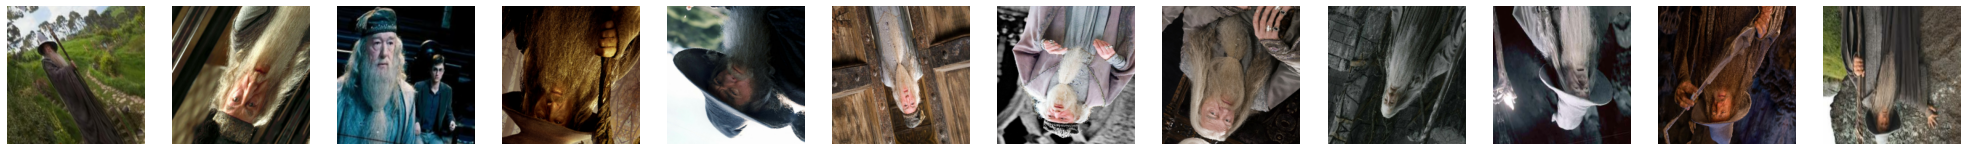

In [97]:
print_sample(
    sample_size=12, 
    tfds=augmented_train_set, 
    fgs=35
)

---
Transfer Learning:

For this model, we are going to use `EfficientNet` whch is a very efficient model for **image classification** and it is commonly use for tansfer learning tasks.

This model has as variables:
  * Resolution
  * Depth
  * Width

In [98]:
# Preparing data:

def preprocess_input(image, label):
  """For each image in the tfds, binarizes the label
  
  Args:
    image (): ?
    label (): ?
    num_classes (): ?
  """

  label = tf.one_hot(int(label), NUM_CLASSES)
  return image, label


In [99]:
train_bin_set = train_set.map(
    preprocess_input, num_parallel_calls = tf.data.AUTOTUNE
)

train_bin_set = train_bin_set.batch(batch_size = BATCH_SIZE, drop_remainder=True)
train_bin_set = train_bin_set.prefetch(tf.data.AUTOTUNE)

In [100]:
type(train_bin_set)

tensorflow.python.data.ops.dataset_ops.PrefetchDataset

In [101]:
validation_bin_set = validation_set.map(preprocess_input)
validation_bin_set = validation_bin_set.batch(batch_size=BATCH_SIZE, drop_remainder=True)

Once we have the Preprocessing in place and the transfer learning loaded, we train a model from scratch

In [102]:
from tensorflow.keras.applications import EfficientNetB1, EfficientNetB0  # B1 240 for resolution in input shape
from keras.models import Sequential
from keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

In [103]:
transfer_layer = EfficientNetB1(
    include_top=False,  # Our own RNN at the end
    weights='imagenet'
)

transfer_layer.trainable = False

In [121]:
# Train params
train_params = {
    "learning_rate": 0.0001,  
    "dropout_rate": 0.1,
    "momentum": 0.99  # Default
}

model = Sequential()

# Transform inputs to add to EfficientNet
model.add(layers.Input(IMG_SIZE+(3,)))

model.add(Sequential(
    [   
        layers.RandomContrast(factor=(0.05,0.15)),
        layers.RandomCrop(IMG_SIZE[0], IMG_SIZE[1], seed = SEED),
        layers.RandomRotation(factor= (-0.1, 0.1), seed=SEED),
        layers.RandomFlip(seed=SEED)
    ], name = 'DATA_AUGMENTATION'
))

# Add frozen EfficientNET with input_tensor 
transfer_layer = EfficientNetB0(
    include_top=False,  # Our own RNN at the end
    weights='imagenet'
)

transfer_layer.trainable = False

model.add(transfer_layer)

# Rebuild top
model.add(Sequential(
    [
        layers.Flatten(name="top_flatten"),
        layers.BatchNormalization(momentum=train_params["momentum"], name='top_norm'),
        layers.Dense(32, activation = 'relu', name='top_dense_1'),
        layers.Dense(32, activation = 'relu', name='top_dense_2'),
        layers.Dropout(train_params["dropout_rate"], name="top_dropout"),
        layers.Dense(1, activation = 'sigmoid', name='top_dense_out')                     
    ], name= 'TOP_LAYER'
))

# Compile and show
optimizer = Adam(learning_rate = train_params["learning_rate"])

model.compile(
    loss = 'binary_crossentropy',
    optimizer = optimizer,
    metrics = ['binary_accuracy']
)

model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 DATA_AUGMENTATION (Sequenti  (None, 224, 224, 3)      0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 TOP_LAYER (Sequential)      (None, 1)                 2259041   
                                                                 
Total params: 6,308,612
Trainable params: 2,133,601
Non-trainable params: 4,175,011
_________________________________________________________________


In [122]:
history = model.fit(
  train_set, 
  epochs=30, 
  callbacks=EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True, min_delta=0.002),
  validation_data=validation_set
)

Epoch 1/30
2/2 [==============================] - 11s 3s/step - loss: 0.8351 - binary_accuracy: 0.4314 - val_loss: 0.7421 - val_binary_accuracy: 0.3750
Epoch 2/30
2/2 [==============================] - 4s 2s/step - loss: 0.5936 - binary_accuracy: 0.7255 - val_loss: 0.6448 - val_binary_accuracy: 0.3750
Epoch 3/30
2/2 [==============================] - 3s 2s/step - loss: 0.5700 - binary_accuracy: 0.7255 - val_loss: 0.5757 - val_binary_accuracy: 0.6875
Epoch 4/30
2/2 [==============================] - 4s 2s/step - loss: 0.4540 - binary_accuracy: 0.7843 - val_loss: 0.5087 - val_binary_accuracy: 0.8125
Epoch 5/30
2/2 [==============================] - 4s 2s/step - loss: 0.3952 - binary_accuracy: 0.8627 - val_loss: 0.4535 - val_binary_accuracy: 0.8750
Epoch 6/30
2/2 [==============================] - 4s 2s/step - loss: 0.2208 - binary_accuracy: 0.9804 - val_loss: 0.4156 - val_binary_accuracy: 0.8750
Epoch 7/30
2/2 [==============================] - 4s 2s/step - loss: 0.2175 - binary_accuracy

In [ ]:
# dev metrics
# confusion matrix
# f1 score
# precision / recall

In [123]:
# Evalua el modelo con los datos de X_test y Y_test
print("Evaluate on test data")
results = model.evaluate(test_set)
print("test loss, test acc:", results)

Evaluate on test data
1/1 [==============================] - 1s 615ms/step - loss: 0.5826 - binary_accuracy: 0.6154
test loss, test acc: [0.5825644135475159, 0.6153846383094788]


In [124]:

def plot_model_history(model_history):
    """ Prints both the accuracy and the loss of the training history
    """
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    

    # Summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['binary_accuracy'])+1),model_history.history['binary_accuracy'])
    axs[0].plot(range(1,len(model_history.history['val_binary_accuracy'])+1),model_history.history['val_binary_accuracy'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')

    axs[0].set_xticks(np.arange(1,len(model_history.history['binary_accuracy'])+1),len(model_history.history['binary_accuracy'])/10)
    axs[0].legend(['train', 'val'], loc='best')

    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])

    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')

    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


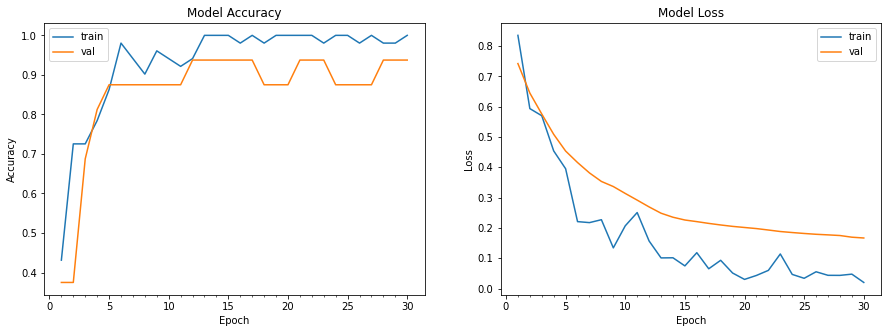

In [125]:
plot_model_history(history)  # sequential_9 -- lr .00010 | do .2

In [126]:
model.save("trial_model.h5")